# Read data

In [171]:

import numpy as np
import pandas as pd
%matplotlib widget
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [172]:
#читаем данные
X_train_new = np.load('./X_train.npy')
X_test_new = np.load('./X_test.npy')

y_train = pd.read_csv('./y_train.csv')
y_test = pd.read_csv('./y_test_predicted.csv')
y_sub = pd.read_csv('./sample_submission.csv')

print(X_train_new.shape, y_train.shape)
print(X_test_new.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [173]:
X_train_new.shape, y_train.shape

((323, 40, 100), (32300, 2))

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

In [174]:
def transform_to_dataframe(arr):
    
    # Создаем DataFrame
    df = pd.DataFrame()

    # Проходимся по каждой плоскости трехмерного массива
    for plane_index in range(arr.shape[2]):
        # Создаем временный двумерный DataFrame для текущей плоскости
        temp_df = pd.DataFrame(arr[:,:,plane_index])

        # Добавляем номер плоскости в качестве префикса к названию столбцов
        temp_df.index = [f'{ind}-{plane_index}' for ind in temp_df.index]

        # Объединяем временный DataFrame с общим трехмерным DataFrame
        df = pd.concat([df, temp_df], axis=0)

    return df

In [175]:
# Трансформируем данные
X_train = transform_to_dataframe(X_train_new)
X_test = transform_to_dataframe(X_test_new)

In [176]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0-0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1-0,1019.0,11.0,1361.0,70.0,32.0,1552.0,136.0,25.0,976.0,12.0,...,1856.0,62.0,19.0,1171.0,128.0,28.0,1652.0,27.0,748.0,23.0
2-0,965.0,10.0,1300.0,51.0,33.0,1475.0,131.0,6.0,911.0,10.0,...,1721.0,59.0,18.0,1161.0,128.0,29.0,1639.0,24.0,685.0,32.0
3-0,1011.0,14.0,1499.0,52.0,17.0,1459.0,152.0,1.0,1185.0,10.0,...,1901.0,70.0,17.0,1231.0,128.0,33.0,1626.0,24.0,869.0,25.0
4-0,703.0,16.0,1235.0,70.0,30.0,1426.0,132.0,3.0,709.0,10.0,...,1388.0,71.0,16.0,1200.0,128.0,28.0,1663.0,10.0,628.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318-99,1385.0,3.0,1945.0,31.0,30.0,2221.0,42.0,8.0,1320.0,16.0,...,2842.0,73.0,16.0,1255.0,109.0,31.0,1604.0,29.0,787.0,21.0
319-99,676.0,4.0,703.0,29.0,18.0,1066.0,28.0,5.0,572.0,6.0,...,899.0,70.0,16.0,1152.0,116.0,21.0,2006.0,27.0,335.0,28.0
320-99,998.0,13.0,760.0,32.0,14.0,710.0,41.0,3.0,930.0,6.0,...,2041.0,72.0,16.0,1219.0,105.0,27.0,1854.0,22.0,591.0,24.0
321-99,1099.0,7.0,1161.0,23.0,13.0,1460.0,37.0,6.0,1126.0,10.0,...,938.0,66.0,8.0,1167.0,114.0,19.0,2030.0,25.0,367.0,22.0


In [177]:
# На потом оставляем индексы прегодятся для дальнейшего преобразования
X_test_index = X_test.index

In [178]:
#Создаем из датафрейма сводную таблицу, сортируем и оставляем только значения
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split(pat='-',n=1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index()
y_train = y_train.values

In [179]:
# Сортируем значения
X_train.reset_index(drop=False, inplace= True)
X_train[['sample_id', 'time']] = X_train['index'].str.split(pat="-", n=1, expand=True).astype(int)
X_train.sort_values(by=['sample_id', 'time'],inplace=True)
X_train.drop(columns=['sample_id','time','index'], inplace=True)

In [180]:
# Повторяем процедуру
X_test.reset_index(drop=False, inplace= True)
X_test[['sample_id', 'time']] = X_test['index'].str.split(pat="-", n=1, expand=True).astype(int)
X_test.sort_values(by=['sample_id', 'time'],inplace=True)
X_test.drop(columns=['sample_id','time','index'], inplace=True)

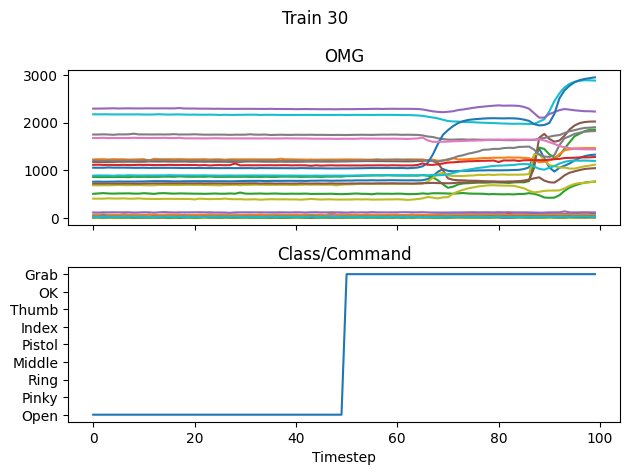

In [181]:
i = 30
fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_train_new[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

In [182]:
y_train = pd.read_csv('./y_train.csv')
y_train.drop('sample-timestep', axis =1, inplace = True)
y_train = y_train.to_numpy()

In [183]:
# Нормализуем и стандартизируем признаки
X_train = RobustScaler().fit_transform(X_train)
X_train = StandardScaler().fit_transform(X_train)

X_test = RobustScaler().fit_transform(X_test)
X_test = StandardScaler().fit_transform(X_test)

In [185]:
%%time
from sklearn.neural_network import MLPClassifier  # многослойный персептрон (просто много полносвязных слоев)
clf = MLPClassifier(activation='logistic', solver='sgd', max_iter=200, random_state=0)
clf.fit(X_train, y_train)

CPU times: total: 1min 21s
Wall time: 1min 9s


MLPClassifier(activation='logistic', random_state=0, solver='sgd')

In [186]:
# Делаем предсказания на новых данных
predict_ = clf.predict(X_test)

In [187]:
# Преобразуем в соответствии с требованиями соревнования
y_test = []
for idx, arr in zip(X_test_index, predict_):
    series = pd.Series(arr)
    series.index = [f"{idx}" for i in series.index]
    y_test.append(series)

y_test = pd.concat(y_test)
y_test = y_test.reset_index()
y_test.columns = ["sample-timestep", "class"]
y_test[['sample_id', 'time']] = y_test['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_test.sort_values(by=['sample_id', 'time'],inplace=True)
y_test.drop(columns=['sample_id','time'], inplace=True)
y_test.head(3)

,sample-timestep,class
0,0-0,4
54,0-1,4
108,0-2,0


In [188]:
y_test['sample-timestep'] = y_sub['sample-timestep']
y_test.head()

,sample-timestep,class
0,323-0,4
54,323-54,4
108,324-8,0
162,324-62,0
216,325-16,0


In [189]:
# Создаем новый csv файл с нашими результатами
y_test.to_csv('./y_test_predicted.csv', index=False)

In [190]:
y_test['class'].value_counts()

0    3246
1     298
6     293
5     288
3     275
8     265
2     256
7     247
4     232
Name: class, dtype: int64